# Predicting Real Estate Prices with a Neural Network

This notebook demonstrates how to build and train a simple neural network for a regression task using the `clownpiece` library.

Our goal is to predict the price of a house based on a set of features. To do this, we will:
1.  **Generate a synthetic dataset** that mimics real-world housing data, including features like area, age, and location.
2.  **Define a Multi-Layer Perceptron (MLP)** model using `clownpiece.nn.Sequential`.
3.  **Train the model** by minimizing the Mean Squared Error (MSE) between its predictions and the true prices.
4.  **Visualize the training progress** by plotting the loss curve.

In [1]:
import sys
sys.path.append('../../../')

import math
import numpy as np
import matplotlib.pyplot as plt

from clownpiece import Tensor
from clownpiece.autograd import no_grad
from clownpiece.nn import Module, Linear, Tanh, Sequential, MSELoss, LayerNorm, BatchNorm, LeakyReLU

### 1. Generating Synthetic Data

First, we need data to train our model on. Instead of loading a real dataset, we'll generate a synthetic one. This gives us full control over the features and their relationship with the target variable (price).

We will create the following features:
- `area`: The square footage of the house.
- `house_age`: The age of the house in years.
- `distance_to_city_center`: The distance from the house to the city center in kilometers.
- `num_convenience_stores`: The number of convenience stores in the vicinity.
- `has_yard`: A binary feature indicating whether the house has a yard (1) or not (0).

The price will be a non-linear combination of these features with some added random noise to make the task more realistic. Finally, we'll normalize the features to have a mean of 0 and a standard deviation of 1. Normalization is a crucial preprocessing step that helps stabilize and speed up the training process.

In [2]:
# Generate synthetic data
np.random.seed(0)
num_train_samples = 2000
num_test_samples = 500

noise_level = 0  # noise level for price generation

# Features: area, house_age, distance_to_city_center, num_convenience_stores, has_yard
def get_features(num_samples):
  area = np.random.uniform(50, 250, (num_samples, 1))  # area in sq meters
  house_age = np.random.uniform(0, 50, (num_samples, 1))  # years
  distance_to_city_center = np.random.uniform(1, 25, (num_samples, 1))  # km
  num_convenience_stores = np.random.randint(0, 11, (num_samples, 1))
  has_yard = np.random.randint(0, 2, (num_samples, 1))
  return np.hstack([area, house_age, distance_to_city_center, num_convenience_stores, has_yard])

# Price is a non-linear combination of features + noise
import numpy as np

def get_price(X_raw, noise_level=10):
    area, house_age, distance_to_city_center, num_convenience_stores, has_yard = np.hsplit(X_raw, 5)
    num_samples = X_raw.shape[0]

    # Slightly sublinear area effect (diminishing returns)
    area_term = 10 * (area ** 0.95)

    # House age penalty: mild quadratic
    age_term = -0.5 * (house_age ** 2) + 2.0 * house_age

    # Distance: smooth non-linear decay
    distance_term = -25 * np.sqrt(distance_to_city_center)

    # Convenience stores: log-scale to saturate
    store_term = 6 * np.log1p(num_convenience_stores)

    # Yard bonus (binary)
    yard_term = has_yard * 30.0

    # Interactions
    area_store_interaction = 0.04 * area * np.log1p(num_convenience_stores)
    yard_distance_interaction = -4.0 * has_yard * np.sqrt(distance_to_city_center)
    age_distance_interaction = -0.1 * house_age * distance_to_city_center

    noise = np.random.randn(num_samples, 1) * noise_level

    return (
        100 + area_term + age_term + distance_term +
        store_term + yard_term +
        area_store_interaction + yard_distance_interaction +
        age_distance_interaction + noise
    )

X_raw = get_features(num_train_samples)
Y_raw = get_price(X_raw)

# Normalize features / label for better training stability
X_mean = X_raw.mean(axis=0)
X_std = X_raw.std(axis=0)
Y_mean = Y_raw.mean(axis=0)
Y_std = Y_raw.std(axis=0)

def normalize_X(X_raw, X_mean=X_mean, X_std=X_std):
    return (X_raw - X_mean) / X_std
def normalize_Y(Y_raw, Y_mean=Y_mean, Y_std=Y_std):
    return (Y_raw - Y_mean) / Y_std
def denormalize_Y(Y_norm, Y_mean=Y_mean, Y_std=Y_std):
    return Y_norm * Y_std + Y_mean


# Get train set
X = Tensor(normalize_X(X_raw).tolist(), requires_grad=False)
y = Tensor(normalize_Y(Y_raw).tolist(), requires_grad=False)

# Get test set
X_test_raw = get_features(num_test_samples)
Y_test_raw = get_price(X_test_raw)
X_test = Tensor(normalize_X(
                X_test_raw).tolist(), 
                requires_grad=False)
y_test = Tensor(normalize_Y(
                Y_test_raw).tolist(), requires_grad=False)

print("Train Features shape:", X.shape)
print("Train Target shape:", y.shape)
print("Test Features shape:", X_test.shape)
print("Test Target shape:", y_test.shape)

print("Sample X, y:")
print(X[:5])
print(y[:5])

Train Features shape: [2000, 5]
Train Target shape: [2000, 1]
Test Features shape: [500, 5]
Test Target shape: [500, 1]
Sample X, y:
(Tensor(
  shape=(5, 5), strides=(5, 1)
  data={
    [[0.153192, 1.10576, -0.693062, -1.6635, 0.999],
     [0.717352, -0.0644997, 0.264265, -0.707741, -1.001],
     [0.336129, 0.0997242, -1.23566, 1.20378, 0.999],
     [0.139865, -0.851441, -0.493575, 1.52237, 0.999],
     [-0.271206, 0.38541, -1.52997, 1.52237, 0.999]]
  }
)
, requires_grad=False, grad_fn=None)
(Tensor(
  shape=(5, 1), strides=(1, 1)
  data={
    [[-0.488842],
     [0.753032],
     [0.517542],
     [0.740565],
     [-0.0736396]]
  }
)
, requires_grad=False, grad_fn=None)


### 2. Defining the Model Architecture

Now we'll define our neural network. We'll use a simple Multi-Layer Perceptron (MLP), which is a good starting point for many regression problems.

Our model will be constructed using the `Sequential` container, which makes it easy to stack layers in order. The architecture will be:
- A `Linear` layer that takes our 5 input features and maps them to 32 hidden units.
- A `LayerNorm` layer to normalize the activations.
- A `Tanh` activation function to introduce non-linearity.
- Another `Linear` layer from 32 to 16 units.
- A `BatchNorm` layer.
- Another `LeakyReLU` activation.
- A final `Linear` layer that maps the 16 hidden units to a single output value: the predicted price.

This is quite a dummy model out of nowhere. Let's see if it can fit the price.

> P.S.: Applying `LayerNorm, BatchNorm` in such a small model is usually unnecessary (and potentially harmful). We use it only for demonstrative purpose.

In [3]:
# Define the model
input_features = 5
output_features = 1

model = Sequential(
    Linear(input_features, 32),
    LayerNorm(32),
    Tanh(),
    Linear(32, 16),
    BatchNorm(16),
    LeakyReLU(),
    Linear(16, output_features)
)

print("Model Architecture:")
print(model)

Model Architecture:
Sequential(
 (0): Linear(in_features=5, out_features=32, bias=True)
 (1): LayerNorm(num_features=32, eps=1e-05, affine=True)
 (2): Tanh()
 (3): Linear(in_features=32, out_features=16, bias=True)
 (4): BatchNorm(num_features=16, eps=1e-05, affine=True, momentum=0.1)
 (5): LeakyReLU()
 (6): Linear(in_features=16, out_features=1, bias=True)
)


### 3. Training the Model

With the data and model ready, we can begin training. This involves setting up our loss function and then looping through the data for a set number of epochs.

- **Loss Function**: We'll use `MSELoss` (Mean Squared Error), which is the standard loss function for regression tasks. 
- **Training Loop**: For each epoch, we split `X, y` into batches (a batch $\to$ an iteration); then we perform the following steps for each iteration:
    1.  **Forward Pass**: Pass the input data `X` through the model to get predictions.
    2.  **Calculate Loss**: Compute the MSE loss between the predictions and the true targets `y`.
    3.  **Backward Pass**: Call `loss.backward()` to compute the gradients of the loss with respect to all model parameters.
    4.  **Update Weights**: Manually adjust the model's parameters since we do not have an optimizer yet. We subtract the gradient (scaled by the learning rate `lr`) from each parameter to perform **gradient descent**.
    5.  **Zero Gradients**: Manually clear the gradients so they don't accumulate in the next iteration.

In [4]:
# Loss and training parameters
loss_fn = MSELoss()

batch_size = 50
init_lr = 3e-4
epochs = 400


def get_lr(epoch, epochs = epochs, init_lr = init_lr, final_lr = init_lr / 50):
  # exponential lr scheduler
  beta = math.log(final_lr / init_lr) / epochs
  return init_lr * math.exp(beta * epoch)
  
# Initialize lists to track losses
train_losses = []
test_losses = []

In [5]:
# Training loop
for epoch in range(epochs):
    sum_train_loss = 0
    for i in range(0, num_train_samples, batch_size):
        # Forward pass
        model.train()
        X_batch = X[i:i+batch_size]
        y_batch = y[i:i+batch_size]
        predictions = model(X_batch)

        # Calculate loss
        loss = loss_fn(predictions, y_batch)
        sum_train_loss += loss.item()

        # Backward pass
        loss.backward()

        # Update weights (manual gradient descent)
        with no_grad():
            lr = get_lr(epoch)
            for param in model.parameters():
                if param.grad is not None:
                    param.copy_(param - param.grad * lr)
        
        # Zero gradients for the next iteration
        for param in model.parameters():
            if param.grad is not None:
                param.grad = None
                
    avg_train_loss = sum_train_loss / (num_train_samples / batch_size)
    train_losses.append(avg_train_loss)
            
    # Predict on test set
    with no_grad():
        model.eval()
        test_predictions = model(X_test)
        avg_test_loss = loss_fn(test_predictions, y_test).item()
        test_losses.append(avg_test_loss)

    if (epoch + 1) % 10 == 0 or epoch < 10:
        print(f"Epoch {epoch+1:3}/{epochs}, train loss: {avg_train_loss:.3f}, test loss: {avg_test_loss:.3f}")

[1] [50, 1]
[50, 1] [50, 32]
[50, 1] [50, 32]
[1] [50, 1]
[50, 1] [50, 32]
[50, 1] [50, 32]
[1] [50, 1]
[50, 1] [50, 32]
[50, 1] [50, 32]
[1] [50, 1]
[50, 1] [50, 32]
[50, 1] [50, 32]
[1] [50, 1]
[50, 1] [50, 32]
[50, 1] [50, 32]
[1] [50, 1]
[50, 1] [50, 32]
[50, 1] [50, 32]
[1] [50, 1]
[50, 1] [50, 32]
[50, 1] [50, 32]
[1] [50, 1]
[50, 1] [50, 32]
[50, 1] [50, 32]
[1] [50, 1]
[50, 1] [50, 32]
[50, 1] [50, 32]
[1] [50, 1]
[50, 1] [50, 32]
[50, 1] [50, 32]
[1] [50, 1]
[50, 1] [50, 32]
[50, 1] [50, 32]
[1] [50, 1]
[50, 1] [50, 32]
[50, 1] [50, 32]
[1] [50, 1]
[50, 1] [50, 32]
[50, 1] [50, 32]
[1] [50, 1]
[50, 1] [50, 32]
[50, 1] [50, 32]
[1] [50, 1]
[50, 1] [50, 32]
[50, 1] [50, 32]
[1] [50, 1]
[50, 1] [50, 32]
[50, 1] [50, 32]
[1] [50, 1]
[50, 1] [50, 32]
[50, 1] [50, 32]
[1] [50, 1]
[50, 1] [50, 32]
[50, 1] [50, 32]
[1] [50, 1]
[50, 1] [50, 32]
[50, 1] [50, 32]
[1] [50, 1]
[50, 1] [50, 32]
[50, 1] [50, 32]
[1] [50, 1]
[50, 1] [50, 32]
[50, 1] [50, 32]
[1] [50, 1]
[50, 1] [50, 32]
[50, 

### 4. Visualizing the Results

Finally, we'll plot the training and test loss over epochs. This is a simple but effective way to diagnose the training process. If the model is learning correctly, we should see the loss decrease steadily over time and then plateau as it converges. 

Min test loss achieved: 0.040


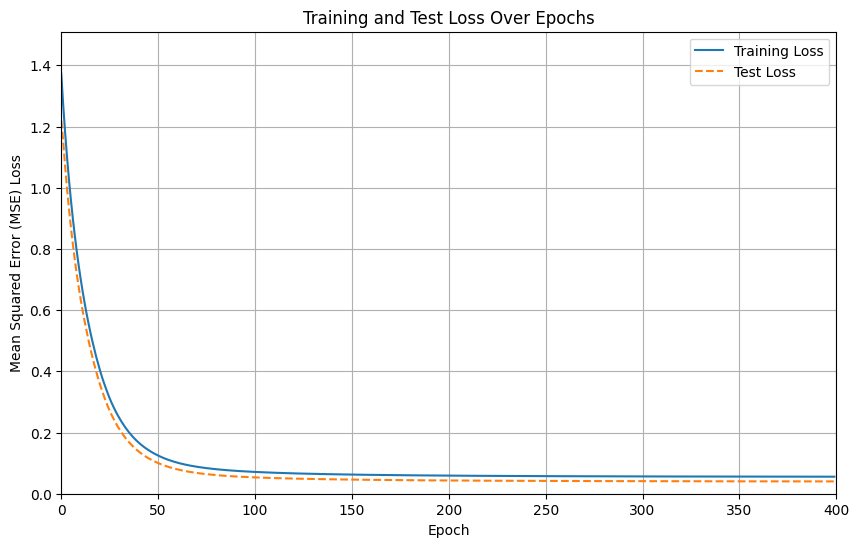

In [6]:
# Visualize Training and Test Loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss', linestyle='--')
plt.title("Training and Test Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error (MSE) Loss")
plt.xlim(0, epochs)
plt.ylim(0, max(max(train_losses[0:]), max(test_losses[0:])) * 1.1)
print(f"Min test loss achieved: {min(test_losses):.3f}")
plt.legend()
plt.grid(True)
plt.show()

---

If everything works correctly, you should achieve $\text{test\_loss}\approx 0.01$.
Inaccurately speaking, it indicates an average error of $0.1 \sigma$.

> P.S.: It's common that test loss fluctuates after convergence: this may due to overfitting or inproper learning rate scheduling (too large at late epochs). Try to adjust `get_lr()` if that bothers you.

---
# Exploratory Task

Try to alter the model structure (e.g. remove normalization layers, increase hidden layer number and size) and adjust learning rate to see if it achieves a better test loss or faster/stabler convergence.

> This exploratory task is not graded.